[View in Colaboratory](https://colab.research.google.com/github/Baileyswu/google-tensorflow-tutor/blob/master/7.%20logistic_regression.ipynb)

#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 逻辑回归

 **学习目标：**
  * 将（在之前的练习中构建的）房屋价值中位数预测模型重新构建为二元分类模型
  * 比较逻辑回归与线性回归解决二元分类问题的有效性

 与在之前的练习中一样，我们将使用加利福尼亚州住房数据集，但这次我们会预测某个城市街区的住房成本是否高昂，从而将其转换成一个二元分类问题。此外，我们还会暂时恢复使用默认特征。

 ## 将问题构建为二元分类问题

数据集的目标是 `median_house_value`，它是一个数值（连续值）特征。我们可以通过向此连续值使用阈值来创建一个布尔值标签。

我们希望通过某个城市街区的特征预测该街区的住房成本是否高昂。为了给训练数据和评估数据准备目标，我们针对房屋价值中位数定义了分类阈值 - 第 75 百分位数（约为 265000）。所有高于此阈值的房屋价值标记为 `1`，其他值标记为 `0`。

 ## 设置

运行以下单元格，以加载数据并准备输入特征和目标。

In [2]:
#coding=utf-8
import pandas as pd

def arff_to_csv(fpath):
    #读取arff数据
    if fpath.find('.arff') < 0:
        print('the file is not .arff file')
        return
    f = open(fpath)
    filename = fpath[:fpath.find('.arff')] + '.csv'
    tof = open(filename, 'w+')
    lines = f.readlines()
    content = []
    flag = 0
    for x in lines:
        if "@relation" in x or "@data" in x:
            continue
        cs = x.split(' ')
        if "@attribute" in cs:
            if flag == 1:
                tof.write(',')
            tof.write(cs[1])
            flag = 1
        else:
            tof.write(x)
    f.close()
    tof.close()

csv_data= arff_to_csv("ThoraricSurgery.arff")

In [3]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("ThoraricSurgery.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [4]:
california_housing_dataframe

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
112,DGN3,3.7,64.1,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,60,F
148,DGN3,3.6,2.8,PRZ1,F,F,F,T,F,OC12,F,F,F,T,F,74,F
442,DGN2,4.1,2.2,PRZ1,F,F,T,T,F,OC12,F,F,F,F,F,61,F
38,DGN3,4.2,3.1,PRZ0,F,F,F,F,F,OC11,F,F,F,T,F,56,F
346,DGN2,3.5,2.8,PRZ1,F,F,F,F,T,OC11,F,F,F,T,F,58,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,DGN2,2.8,1.6,PRZ1,F,T,F,T,T,OC12,F,F,F,T,F,53,T
110,DGN2,4.5,4.2,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,55,F
22,DGN3,2.4,1.7,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,62,F
32,DGN5,2.5,1.9,PRZ1,T,F,F,F,F,OC12,T,F,F,F,F,72,F


In [5]:
DGN_mapping = {
    'DGN3': 3,
    'DGN2': 2,
    'DGN4': 4,
    'DGN6': 6,
    'DGN5': 5,
    'DGN8': 8,
    'DGN1': 1
}
PRZ_mapping = {
    'PRZ0' : 0,
    'PRZ1' : 1,
    'PRZ2' : 2
}
OC_mapping = {
    'OC11': 11,
    'OC12': 12,
    'OC13': 13,
    'OC14': 14
}
TF_mapping = {
    'T' : 1,
    'F' : 0
}
california_housing_dataframe['DGN'] = california_housing_dataframe['DGN'].map(DGN_mapping)
california_housing_dataframe['PRE6'] = california_housing_dataframe['PRE6'].map(PRZ_mapping)
california_housing_dataframe['PRE14'] = california_housing_dataframe['PRE14'].map(OC_mapping)
california_housing_dataframe['PRE7'] = california_housing_dataframe['PRE7'].map(TF_mapping)
california_housing_dataframe['PRE8'] = california_housing_dataframe['PRE8'].map(TF_mapping)
california_housing_dataframe['PRE9'] = california_housing_dataframe['PRE9'].map(TF_mapping)
california_housing_dataframe['PRE10'] = california_housing_dataframe['PRE10'].map(TF_mapping)
california_housing_dataframe['PRE11'] = california_housing_dataframe['PRE11'].map(TF_mapping)
california_housing_dataframe['PRE17'] = california_housing_dataframe['PRE17'].map(TF_mapping)
california_housing_dataframe['PRE19'] = california_housing_dataframe['PRE19'].map(TF_mapping)
california_housing_dataframe['PRE25'] = california_housing_dataframe['PRE25'].map(TF_mapping)
california_housing_dataframe['PRE30'] = california_housing_dataframe['PRE30'].map(TF_mapping)
california_housing_dataframe['PRE32'] = california_housing_dataframe['PRE32'].map(TF_mapping)
california_housing_dataframe['Risk1Yr'] = california_housing_dataframe['Risk1Yr'].map(TF_mapping)

california_housing_dataframe

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
112,3,3.7,64.1,0,0,0,0,0,0,12,0,0,0,1,0,60,0
148,3,3.6,2.8,1,0,0,0,1,0,12,0,0,0,1,0,74,0
442,2,4.1,2.2,1,0,0,1,1,0,12,0,0,0,0,0,61,0
38,3,4.2,3.1,0,0,0,0,0,0,11,0,0,0,1,0,56,0
346,2,3.5,2.8,1,0,0,0,0,1,11,0,0,0,1,0,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2,2.8,1.6,1,0,1,0,1,1,12,0,0,0,1,0,53,1
110,2,4.5,4.2,0,0,0,0,0,0,12,0,0,0,1,0,55,0
22,3,2.4,1.7,0,0,0,0,0,0,12,0,0,0,1,0,62,0
32,5,2.5,1.9,1,1,0,0,0,0,12,1,0,0,0,0,72,0


In [6]:
california_housing_dataframe.describe()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
count,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0
mean,3.1,3.3,4.6,0.8,0.1,0.1,0.1,0.7,0.2,11.7,0.1,0.0,0.0,0.8,0.0,62.5,0.1
std,0.7,0.9,11.8,0.5,0.2,0.4,0.2,0.5,0.4,0.7,0.3,0.1,0.1,0.4,0.1,8.7,0.4
min,1.0,1.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
25%,3.0,2.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,57.0,0.0
50%,3.0,3.2,2.4,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,62.0,0.0
75%,3.0,3.8,3.1,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,69.0,0.0
max,8.0,6.3,86.3,2.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,87.0,1.0


 注意以下代码与之前练习中的代码之间稍有不同。我们并没有将 `median_house_value` 用作目标，而是创建了一个新的二元目标 `median_house_value_is_high`。

In [7]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [
     "DGN","PRE4","PRE5","PRE6","PRE7","PRE8","PRE9","PRE10","PRE11","PRE14","PRE17","PRE19","PRE25","PRE30","PRE32","AGE"
    ]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
#   processed_features["rooms_per_person"] = (
#     california_housing_dataframe["total_rooms"] /
#     california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["one_will_die"] = california_housing_dataframe["Risk1Yr"] 
  return output_targets

In [8]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(300))
training_targets = preprocess_targets(california_housing_dataframe.head(300))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(160))
validation_targets = preprocess_targets(california_housing_dataframe.tail(160))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,3.1,3.3,3.9,0.7,0.1,0.1,0.1,0.7,0.1,11.7,0.1,0.0,0.0,0.8,0.0,61.8
std,0.7,0.9,9.5,0.6,0.2,0.3,0.3,0.5,0.3,0.7,0.3,0.1,0.1,0.4,0.1,8.1
min,1.0,1.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,21.0
25%,3.0,2.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,57.0
50%,3.0,3.2,2.4,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,61.0
75%,3.0,3.8,3.0,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,68.0
max,8.0,5.6,79.3,2.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,81.0


Validation examples summary:


,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
count,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
mean,3.1,3.3,5.2,0.9,0.1,0.2,0.1,0.8,0.2,11.8,0.1,0.0,0.0,0.9,0.0,64.2
std,0.7,0.9,13.9,0.5,0.3,0.4,0.2,0.4,0.4,0.7,0.3,0.1,0.2,0.3,0.0,9.6
min,2.0,1.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,39.0
25%,3.0,2.6,2.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,57.0
50%,3.0,3.1,2.4,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,64.0
75%,3.0,3.9,3.1,1.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,72.0
max,6.0,6.3,86.3,2.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,0.0,87.0


Training targets summary:


,one_will_die
count,300.0
mean,0.1
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,one_will_die
count,160.0
mean,0.1
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


 ## 线性回归会有怎样的表现？
为了解逻辑回归为什么有效，我们首先训练一个使用线性回归的简单模型。该模型将使用 `{0, 1}` 中的值为标签，并尝试预测一个尽可能接近 `0` 或 `1` 的连续值。此外，我们希望将输出解读为概率，所以最好模型的输出值可以位于 `(0, 1)` 范围内。然后我们会应用阈值 `0.5`，以确定标签。

运行以下单元格，以使用 [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) 训练线性回归模型。

In [9]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

In [10]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  age = tf.feature_column.numeric_column("AGE")
  bucketized_age = tf.feature_column.bucketized_column(
    age, boundaries=get_quantile_based_boundaries(
      training_examples["AGE"], 10)
  )
  feature_columns = set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])
  feature_columns.add(bucketized_age)
  return feature_columns

In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.  
  training_input_fn = lambda: my_input_fn(
    training_examples, 
    training_targets["one_will_die"], 
    batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
    training_examples, 
    training_targets["one_will_die"], 
    num_epochs=1, 
    shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
    validation_examples, 
    validation_targets["one_will_die"], 
    num_epochs=1, 
    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 10.00
  period 01 : 9.86
  period 02 : 9.68
  period 03 : 9.57
  period 04 : 9.56
  period 05 : 9.54
  period 06 : 9.56
  period 07 : 9.67
  period 08 : 9.85
  period 09 : 9.99
Model training finished.


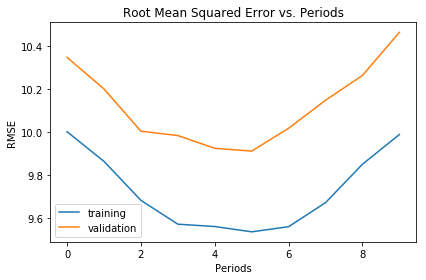

In [13]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.1,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 1：我们可以计算这些预测的对数损失函数吗？

**检查预测，并确定是否可以使用它们来计算对数损失函数。**

`LinearRegressor` 使用的是 L2 损失，在将输出解读为概率时，它并不能有效地惩罚误分类。例如，对于概率分别为 0.9 和 0.9999 的负分类样本是否被分类为正分类，二者之间的差异应该很大，但 L2 损失并不会明显区分这些情况。

相比之下，`LogLoss`（对数损失函数）对这些"置信错误"的惩罚力度更大。请注意，`LogLoss` 的定义如下：

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


但我们首先需要获得预测值。我们可以使用 `LinearRegressor.predict` 获得预测值。

我们可以使用预测和相应目标计算 `LogLoss` 吗？

解读 `LogLoss`（对数损失函数）：  
当实际是负样本，y=0，$Log Loss = \sum_{(x,y)\in D} - log(1 - y_{pred})$，$y_{pred}$ 越大，损失越大。并且 0.9 和 0.9999 差异很大。  
当实际是正样本，y=1，$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred})$，$y_{pred}$ 越小，损失越大。并且 0.1 和 0.0001 差异很大。

 ### 解决方案

点击下方即可查看解决方案。

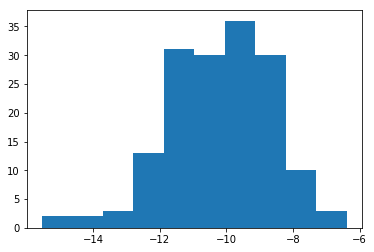

In [14]:
predict_validation_input_fn = lambda: my_input_fn(
    validation_examples, 
    validation_targets["one_will_die"], 
    num_epochs=1, 
    shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

In [15]:
validation_predictions_dataframe = pd.DataFrame()
validation_predictions_dataframe['predictions'] = validation_predictions
validation_predictions_dataframe.describe()

,predictions
count,160.0
mean,-10.2
std,1.6
min,-15.5
25%,-11.2
50%,-10.1
75%,-9.0
max,-6.4


取值有在 [0, 1] 之外的，还需要经 S 型函数转化到概率值。

 ## 任务 2：训练逻辑回归模型并计算验证集的对数损失函数

要使用逻辑回归非常简单，用 [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) 替代 `LinearRegressor` 即可。完成以下代码。

**注意**：在 `LinearClassifier` 模型上运行 `train()` 和 `predict()` 时，您可以通过返回的字典（例如 `predictions["probabilities"]`）中的 `"probabilities"` 键获取实值预测概率。Sklearn 的 [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) 函数可基于这些概率计算对数损失函数，非常方便。


In [16]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )# YOUR CODE HERE: Construct the linear classifier.
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
    training_examples, 
    training_targets["one_will_die"], 
    batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
    training_examples, 
    training_targets["one_will_die"], 
    num_epochs=1, 
    shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
    validation_examples, 
    validation_targets["one_will_die"], 
    num_epochs=1, 
    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [24]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000001,
    steps=800,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
LogLoss (on training data):


KeyError: 'median_house_value_is_high'

 ### 解决方案

点击下方即可查看解决方案。



In [18]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [19]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
LogLoss (on training data):


KeyError: 'median_house_value_is_high'

 ## 任务 3：计算准确率并为验证集绘制 ROC 曲线

分类时非常有用的一些指标包括：模型[准确率](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)、[ROC 曲线](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)和 ROC 曲线下面积 (AUC)。我们会检查这些指标。

`LinearClassifier.evaluate` 可计算准确率和 AUC 等实用指标。

In [20]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.46
Accuracy on the validation set: 0.86


 您可以使用类别概率（例如由 `LinearClassifier.predict` 
和 Sklearn 的 [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 计算的概率）来获得绘制 ROC 曲线所需的真正例率和假正例率。

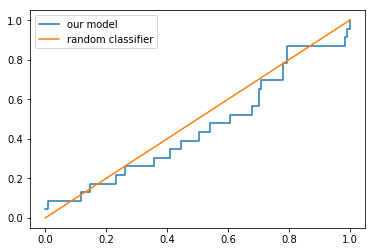

In [21]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

 **看看您是否可以调整任务 2 中训练的模型的学习设置，以改善 AUC。**

通常情况下，某些指标在提升的同时会损害其他指标，因此您需要找到可以实现理想折中情况的设置。

**验证所有指标是否同时有所提升。**

In [22]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=1000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

Training model...
LogLoss (on training data):


KeyError: 'median_house_value_is_high'

 一个可能有用的解决方案是，只要不过拟合，就训练更长时间。

要做到这一点，我们可以增加步数和/或批量大小。

所有指标同时提升，这样，我们的损失指标就可以很好地代理 AUC 和准确率了。

注意它是如何进行很多很多次迭代，只是为了再尽量增加一点 AUC。这种情况很常见，但通常情况下，即使只有一点小小的收获，投入的成本也是值得的。

In [23]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=1000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
LogLoss (on training data):


KeyError: 'median_house_value_is_high'